<a href="https://colab.research.google.com/github/JoDeMiro/DeepLearningIntroduction/blob/main/Sklearn_Online_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scikit Learn

### Hogyan használjuk az incremental learninget helyesen

Az eredeti cikk forássa az alábbi címen található:

https://coderzcolumn.com/tutorials/machine-learning/scikit-learn-incremental-learning-for-large-datasets

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

X, Y = datasets.make_regression(n_samples=240000, random_state=123)

print('X.shape = ', X.shape)
print('Y.shape = ', Y.shape)

X.shape =  (240000, 100)
Y.shape =  (240000,)


In [7]:
print('X.nbytes = ', X.nbytes//1024, 'Kbyte')
print('X.nbytes = ', X.nbytes//1024//1024, 'Mbyte')

X.nbytes =  187500 Kbyte
X.nbytes =  183 Mbyte


In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.9, random_state=123)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((216000, 100), (24000, 100), (216000,), (24000,))

### Na erre az átalakításra kíváncsi vagyok

In [11]:
X_train, X_test = X_train.reshape(-1,24,100), X_test.reshape(-1,24,100)
Y_train, Y_test = Y_train.reshape(-1,24), Y_test.reshape(-1,24)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((9000, 24, 100), (1000, 24, 100), (9000, 24), (1000, 24))

Ilyen átalakítást korábban még nem láttam, de nagyon érdekes.

In [12]:
X_train[0].shape, Y_train[0].shape

((24, 100), (24,))

Ha jól értem az `X_train` és az `Y_train`, batcheket, kics adatcsomagokat tartalmaz.

Valahogy úgy, hogy `X_train[0]` az például egy adatcsomag.



### Create and Train Model

In this section, we have created an ML model using `SGDRegressor` class of scikit-learn. We have then looped through data in **batches** and trained this estimator by calling `partial_fit()` method on it for each batch of data. We have also looped through total data **10 times** where each time training will be performed in batches.

Tehát ha jól értem.:

24 méretű batcheket (csomagokat) magyarul a **batch_size** lehetne 24 és 10-szer vagyis az **epoch** lehetne 10, a hagyományos terminológiában.

In [13]:
from sklearn.linear_model import SGDRegressor

regressor = SGDRegressor()

epochs = 10

for k in range(epochs):                               ## Number of loops through data
    for i in range(X_train.shape[0]):                 ## Looping through batches (9000)
        X_batch, Y_batch = X_train[i], Y_train[i]
        regressor.partial_fit(X_batch, Y_batch)       ## Partially fitting data in batches

Az SGDRegressor konstruktorában sok minden van, de ami engem érdekel a fenti vizsgálat szempontjából az a következőek.

```
SGDRegressor(max_iter=1000,
             shuffle=True,
             verbose=0,
             random_state=None,
             learning_rate='invscaling',
             validation_fraction=0.1,
             warm_start=False)
```

1. `max_iter` akkor most az van, hogy mind a **24** mintán amiből van **9000** és **10-szer** végig megy, azon hol végizi el ezt a `max_iter=1000` lépést? Vagy mivel a `partial_fit` metodust hívjuk meg ez az érték deffinició szerűen nem játszik és olyan mintha az értéke 1 lenne? Erre gondolok, szerintem ez a helyzet.



### Evaluate Model Performance on Test Data

In this section, we have evaluated the performance of our trained model on test data. We have looped through test data in batches and made predictions on them. We have then combined the prediction of each batch.

Na ez is nagyon érdkes:

Én simán ráhívtam volna az egész adatra a `predict` függvényt.

In [19]:
from sklearn.metrics import mean_squared_error, r2_score

Y_test_preds = []
for j in range(X_test.shape[0]):                  ## Looping through test batches for making predictions
    Y_preds = regressor.predict(X_test[j])
    Y_test_preds.extend(Y_preds.tolist())

print("Test MSE      : {}".format(mean_squared_error(Y_test.reshape(-1), Y_test_preds)))
print("Test R2 Score : {}".format(r2_score(Y_test.reshape(-1), Y_test_preds)))
print("Y_test.reshape(-1).shape : ", Y_test.reshape(-1).shape)
print("len(Y_test_preds)        :  ", len(Y_test_preds))

Test MSE      : 0.00024876312858854676
Test R2 Score : 0.9999999907249083
Y_test.reshape(-1).shape :  (24000,)
len(Y_test_preds)        :   24000


Hát igen, úgy látom ez a szakszerű módja annak, hogy elvégezzük a becslést, hiszen az `Y_train` és az `Y_test` adatok is batch kötegebe vannak formálva. És értelemszerűen ha ilyen formában tanítottuk a modelt akkor ilyen formában kell csinálnunk a becslést is, hiszen mást nem tudna megenni a model.

In [20]:
print('Y_train.shape = ', Y_train.shape)
print('Y_test.shape  = ', Y_test.shape)

Y_train.shape =  (9000, 24)
Y_test.shape  =  (1000, 24)


### Evaluate Model Performance on Train Data

At last, we have calculated MSE and R^2 scores on the training dataset to check the performance of the model on train data.

In [21]:
from sklearn.metrics import mean_squared_error, r2_score

Y_train_preds = []
for j in range(X_train.shape[0]): ## Looping through train batches for making predictions
    Y_preds = regressor.predict(X_train[j])
    Y_train_preds.extend(Y_preds.tolist())

print("Train MSE      : {}".format(mean_squared_error(Y_train.reshape(-1), Y_train_preds)))
print("Train R2 Score : {}".format(r2_score(Y_train.reshape(-1), Y_train_preds)))
print("Y_train.reshape(-1).shape : ", Y_train.reshape(-1).shape)
print("len(Y_train_preds)        :  ", len(Y_train_preds))

Train MSE      : 0.00024853825291878094
Train R2 Score : 0.9999999907225984
Y_train.reshape(-1).shape :  (216000,)
len(Y_train_preds)        :   216000


In [23]:
print('Ennyiszer látta a model az adatokat : ', regressor.t_)

Ennyiszer látta a model az adatokat :  2160001.0


### MLPRegressor

In [32]:
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler((0, 1))
Y_scaler = MinMaxScaler((0, 1))

X, Y = datasets.make_regression(n_samples=240000, random_state=123)

print('X.shape = ', X.shape)
print('Y.shape = ', Y.shape)

print('X.nbytes = ', X.nbytes//1024, 'Kbyte')
print('X.nbytes = ', X.nbytes//1024//1024, 'Mbyte')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.9, random_state=123)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)


X_train_scaled = X_scaler.fit_transform(X_train)
Y_train_scaled = Y_scaler.fit_transform(Y_train.reshape(-1, 1)).flatten()

X_test_scaled  = X_scaler.transform(X_test)
Y_test_scaled  = Y_scaler.transform(Y_test.reshape(-1, 1)).flatten()

print(X_train_scaled.shape, X_test_scaled.shape, Y_train_scaled.shape, Y_test_scaled.shape)


X.shape =  (240000, 100)
Y.shape =  (240000,)
X.nbytes =  187500 Kbyte
X.nbytes =  183 Mbyte
(216000, 100) (24000, 100) (216000,) (24000,)
(216000, 100) (24000, 100) (216000,) (24000,)


### Na erre az átalakításra kíváncsi vagyok

In [33]:
X_train, X_test = X_train_scaled.reshape(-1,24,100), X_test_scaled.reshape(-1,24,100)
Y_train, Y_test = Y_train_scaled.reshape(-1,24), Y_test_scaled.reshape(-1,24)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((9000, 24, 100), (1000, 24, 100), (9000, 24), (1000, 24))

Ilyen átalakítást korábban még nem láttam, de nagyon érdekes.

In [34]:
X_train[0].shape, Y_train[0].shape

((24, 100), (24,))

Ha jól értem az `X_train` és az `Y_train`, batcheket, kics adatcsomagokat tartalmaz.

Valahogy úgy, hogy `X_train[0]` az például egy adatcsomag.



### Create and Train Model

In this section, we have created an ML model using `MLPRegressor` class of scikit-learn. We have then looped through data in **batches** and trained this estimator by calling `partial_fit()` method on it for each batch of data. We have also looped through total data **10 times** where each time training will be performed in batches.

Tehát ha jól értem.:

24 méretű batcheket (csomagokat) magyarul a **batch_size** lehetne 24 és 10-szer vagyis az **epoch** lehetne 10, a hagyományos terminológiában.

### [ ! ]

Itt viszont lesz egy fundamentális különbség az `SGDRegressor` osztályhoz képest.

Ott ugyanis nem volt megadható a `batch_size` az `MLPRegreessor` esetében igen.

1. Probáljuk meg úgy, hogy az összes adatot ami a köteben szerepel megkapja
2. Próbáljuk meg úgy, hogy csak egy adatot kap meg beállításként.
3. Nézzük meg milyen eredményt ad a `warm_start` bekapcsolása, van-e hatása
4. Nézzük meg, hogy van-e különbség a `fit` és `partial_fit` között.
5. Tudomásom szerint partial_fit esetén nincs hatása a max_iter értékének, de tesztelni kell.

### [ 1 ]

Az első kísérlet.

In [36]:
from sklearn.neural_network import MLPRegressor

mlp1 = MLPRegressor(hidden_layer_sizes=(10, ),
                    activation='relu',
                    solver='sgd',
                    batch_size=24,
                    max_iter=1,
                    learning_rate_init=0.001,
                    shuffle=True,
                    verbose=False,
                    random_state=123,
                    validation_fraction=0.0,
                    n_iter_no_change=98765)

1. `max_iter` akkor most az van, hogy mind a **24** mintán amiből van **9000** és **10-szer** végig megy, azon hol végizi el ezt a `max_iter=1000` lépést? Vagy mivel a `partial_fit` metodust hívjuk meg ez az érték deffinició szerűen nem játszik és olyan mintha az értéke 1 lenne? Erre gondolok, szerintem ez a helyzet.

In [37]:
epochs = 10

for k in range(epochs):                               ## Number of loops through data
    for i in range(X_train.shape[0]):                 ## Looping through batches (9000)
        X_batch, Y_batch = X_train[i], Y_train[i]     ## (24, 100) és (24,)
        mlp1.partial_fit(X_batch, Y_batch)            ## Partially fitting data in batches

### [ 1 ] Evaluate Model Performance on Test Data


In [41]:
from sklearn.metrics import mean_squared_error, r2_score

Y_test_preds = []
for j in range(X_test.shape[0]):                  ## Looping through test batches for making predictions
    Y_preds = mlp1.predict(X_test[j])
    Y_test_preds.extend(Y_preds.tolist())

print("Test MSE      : {}".format(mean_squared_error(Y_test.reshape(-1), Y_test_preds)))
print("Test R2 Score : {}".format(r2_score(Y_test.reshape(-1), Y_test_preds)))
print("Y_test.reshape(-1).shape : ", Y_test.reshape(-1).shape)
print("len(Y_test_preds)        :  ", len(Y_test_preds))

Test MSE      : 0.00025005242167357546
Test R2 Score : 0.981430351001458
Y_test.reshape(-1).shape :  (24000,)
len(Y_test_preds)        :   24000


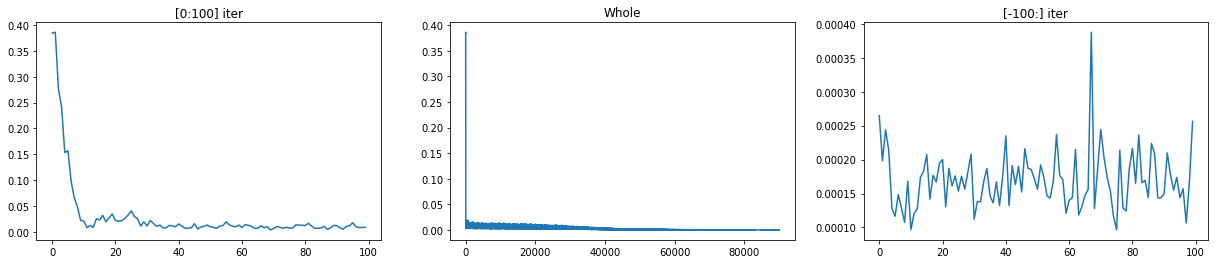

mlp1.t_       :   2160000
Y_train.shape :  (9000, 24)


In [45]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 4))
ax1.plot(mlp1.loss_curve_[0:100])
ax1.set_title('[0:100] iter')
ax2.plot(mlp1.loss_curve_)
ax2.set_title('Whole')
ax3.plot(mlp1.loss_curve_[-100:])
ax3.set_title('[-100:] iter')
plt.show()
print("mlp1.t_       :  ", mlp1.t_)
print("Y_train.shape : ", Y_train.shape)